In [1]:
import openslide, numpy as np, torch, segment_anything, einops, matplotlib.pyplot as plt

torch.set_grad_enabled(False)
#https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

#sam does not work well because:
# * image embeddings are computed at a fixed resolution (1024x1024)
# * it needs some kind of prompts which have to scale with the image size of course (larger image -> more prompts)
# * many prompts needed because
#   * the task is very difficult for SAM
#   * epithelium segmentation are many small disconnected regions
# * SAM does not even perform well on images larger than 320x320
# * SAM outputs 3 segmentation masks. The confidence scores do not correlate with the quality of the segmentation masks

In [ ]:
SAM2 = False
if SAM2:
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    checkpoint = "/local/scratch/clmn1/sam_checkpoints/sam2/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
    predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint).cuda())
else:
    from segment_anything import SamPredictor, sam_model_registry
    sam = sam_model_registry["vit_h"](checkpoint="/local/scratch/clmn1/sam_checkpoints/sam_vit_h_4b8939.pth")
    predictor = SamPredictor(sam.cuda())

/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

In [ ]:
#from sam2.build_sam import build_sam2_video_predictor
#from sam2.build_sam import build_sam2
#from sam2.sam2_image_predictor import SAM2ImagePredictor
#from sam2.sam2_video_predictor import SAM2VideoPredictor
#checkpoint = "/local/scratch/clmn1/sam_checkpoints/sam2/sam2.1_hiera_large.pt"
#model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
#predictor = build_sam2_video_predictor(model_cfg, checkpoint, device="cuda")

In [3]:
subject = "14"
pos_x, pos_y = 14400, 24320
pos_x, pos_y = 14400 - 1000, 24320
size = (30*161, 30*161)
size = (1024, 1024)

slide = openslide.open_slide(f"/local/scratch/PESO/peso_training/pds_{subject}_HE.tif")
slide = slide.read_region((int(pos_x * slide.level_downsamples[1]),
                           int(pos_y * slide.level_downsamples[1])), 1, size)
seg = openslide.open_slide(f"/local/scratch/PESO/peso_training_masks/pds_{subject}_HE_training_mask.tif")
seg = seg.read_region((int(pos_x * seg.level_downsamples[1]),
                           int(pos_y * seg.level_downsamples[1])), 1, size)
slide = np.array(slide)[:,:,0:3]

slide = slide[None]
slide = einops.rearrange(slide, "1 h w c -> h w c")

seg = np.array(seg)[:,:,0]
seg = seg == 2



In [4]:
slide.dtype, slide.shape, seg.dtype, seg.shape

(dtype('uint8'), (1024, 1024, 3), dtype('bool'), (1024, 1024))

In [ ]:
input_img = slide

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
input_prompt_points = []
while len(input_prompt_points) < 50:
    x = np.random.randint(0, input_img.shape[0])
    y = np.random.randint(0, input_img.shape[1])
    if seg[x, y] == True:
        input_prompt_points.append((y, x))

input_prompt_points = np.array(input_prompt_points)
input_prompt_point_labels = np.ones(len(input_prompt_points))



predictor.set_image(input_img)
masks, confidence, _ = predictor.predict(input_prompt_points, input_prompt_point_labels)

print(torch.cuda.max_memory_allocated() / 1024**2)

1313.64599609375


/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:775.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/nlemke/remote/miniconda3/envs

In [6]:
confidence

array([0.00195137, 0.04759981, 0.01857207], dtype=float32)

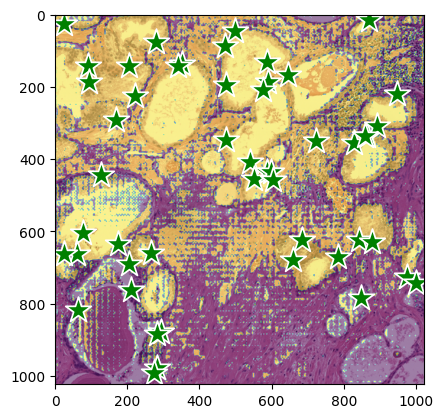

In [10]:
fig, ax = plt.subplots()
plt.imshow(slide)
#plt.imshow(seg, alpha=0.5)
plt.imshow(masks[2], alpha=0.5)
ax.scatter(input_prompt_points[:, 0], input_prompt_points[:, 1], color='green', marker='*', s=375, edgecolor='white', linewidth=1.25)

In [8]:
masks.shape

(3, 1024, 1024)